# Depression & Nutrition

## Exploring whether nutritional intake &  lab nutrient levels can predict depressive symptoms from NHANES

The National Health and Nutrition Examination Survey (NHANES), https://www.cdc.gov/nchs/nhanes/  
Year: 2013-2014

**Data:** .csv files can be downloaded from https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey

**Analysis pipeline:**
* Read + clean data
* Feature selection
    + Create 1 depression score based on the 10 subquestions (https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DPQ_H.htm)
    + Select possibles predictors based on literature?
    + Automatic feature selection
        + Correlation of nutrients with depression score?
            + Nutritional intake vs blood levels
        + Methods???
* Can nutrients predict depression? 
    + Explore different ML models
    + Look at depression subtypes

**Literature:**
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4004962/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2738337/
* http://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-10-16

**Notes:**
* Adjust for: age, education, employment, marital status and average daily caloric intake.
* Sample weight correction


In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

### Data

In [189]:
# read files

demo = pd.read_csv('./data/demographic.csv')
diet = pd.read_csv('./data/diet.csv')
labs = pd.read_csv('./data/labs.csv')
quest = pd.read_csv('./data/questionnaire.csv')

In [190]:
# join data files together

dfname_list = [diet, labs, quest]

dfall = demo
for df in dfname_list: 
    dfall = pd.merge(dfall, df, how='outer', on='SEQN') 

### Features

#### One depression score

A nine-item depression screening instrument, the Patient Health Questionnaire (Kroenke and Spitzer, 2002; Kroenke et al., 2001) was administered to determine the frequency of depression symptoms over the past 2 weeks.  Response categories for the nine-item instrument:

| Value  | Value Description |
|:-------|:-----------------:|
| 0      |     Not at all     
| 1      |    Several days    
| 2      |     More than half the days     
| 3      |      Nearly every day      
| 7      |    Refused    
| 9      |   Don't know

The total score is calculated by finding the sum of 9 items. Remove subject when NaN or more than 2 items 'refused' or 'don't know'. Scores of 10 or higher have been associated with clinically diagnosed depression.

In [191]:
# make list of depression items

itemnumbers = range(10,100,10)

listofitems = []
for item in itemnumbers:
    listofitems.append('DPQ0' + str(item))


In [192]:
# cleaning

df_depression = dfall[listofitems]
df_depression.index = dfall['SEQN']
df_depression = df_depression.dropna()

# per row, count number of 7 and 9 -> remove row when > 2
count_refuse_dont = (df_depression==7).sum(axis=1) + (df_depression==9).sum(axis=1)
df_depression = df_depression[~(count_refuse_dont > 2)]


In [193]:
# one score

df_depression['DepressionScore'] = df_depression.sum(axis=1)

In [194]:
'Number of clinically depressed subjects: %d' %(df_depression['DepressionScore'] >= 10).sum()

'Number of clinically depressed subjects: 525'

In [195]:
# Add depressed yes / no column

df_depression['Depressed'] = (df_depression['DepressionScore'] >= 10)
df_depression.head()

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DepressionScore,Depressed
SEQN,,,,,,,,,,,
73557,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
73558,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,False
73559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
73561,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,9.0,False
73562,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,19.0,True


#### Features/ nutrients from literature

| From literature | Code diet D1 | Code lab
|:----------------|:------------:|:---------:|
| B1              | DR1TVB1      | NA    
| B2              | DR1TVB2      | NA    
| B6              | DR1TVB6      | NA   
| B12             | DR1TVB12     | LBDB12
| Folate          | DR1TFOLA     | NA
| ----------------|--------------|-----------
| Calcium         | DR1TCALC     | LBXSCA  
| Iodine          | NA           | URXUIO 
| Selenium        | DR1TSELE     | LBXSSE   
| Zinc            | DR1TZINC     | LBXSZN
| Magnesium       | DR1TMAGN     | NA
| ----------------|--------------|-----------
| Mono unsat FA   | DR1TMFAT     | NA
| Poly unsat FA   | DR1TPFAT     | NA
| Sat FA          | DR1TSFAT     | NA

.... and more to come

In [196]:
vitamins_diet = ['DR1TVB1', 'DR1TVB2', 'DR1TVB6', 'DR1TVB12', 'DR1TFOLA']

In [197]:
minerals_diet = ['DR1TCALC', 'DR1TSELE', 'DR1TZINC', 'DR1TMAGN']

In [198]:
fat_diet = ['DR1TMFAT', 'DR1TPFAT', 'DR1TSFAT']

#### Explore correlations

In [218]:
# vitamin df
df_vit = dfall[vitamins_diet]
df_vit.index = dfall['SEQN']
df_vit = df_vit.dropna()

# merge with depression df
df_vit_depr = pd.concat([df_vit, df_depression], axis=1, join='inner')
df_vit_depr.head()

,DR1TVB1,DR1TVB2,DR1TVB6,DR1TVB12,DR1TFOLA,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DepressionScore,Depressed
SEQN,,,,,,,,,,,,,,,,
73557,1.057,1.216,0.951,2.79,285.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
73558,4.178,5.168,4.415,21.45,1243.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,False
73559,1.648,1.747,1.906,3.78,423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
73561,1.484,1.720,2.757,8.30,390.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,9.0,False
73562,1.227,1.920,1.892,1.68,458.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,19.0,True


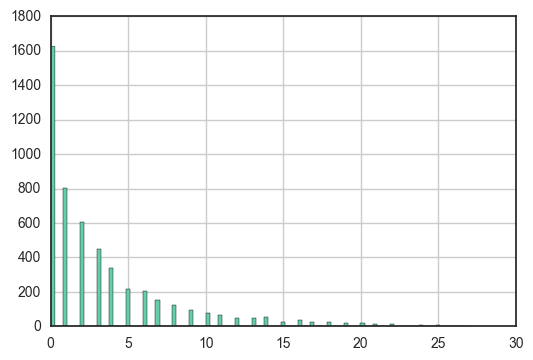

In [200]:
df_vit_depr['DepressionScore'].hist(bins=100, color='mediumaquamarine')

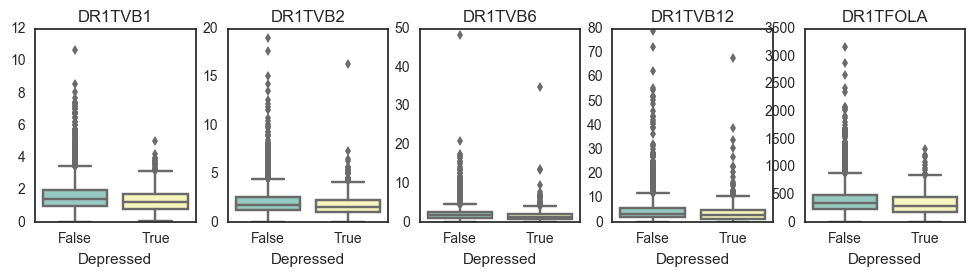

In [227]:
# Boxplots depressed - vitam

f, axes = plt.subplots(1, len(vitamins_diet), sharey=False, figsize=(12,2.5))

i=0
for vitamin in vitamins_diet:
    ax_curr = axes[i]
    sns.boxplot(x="Depressed", y=vitamin, data=df_vit_depr, palette="Set3", ax=ax_curr)
    ax_curr.set_title(vitamin)
    ax_curr.set_ylabel('')
    i+=1

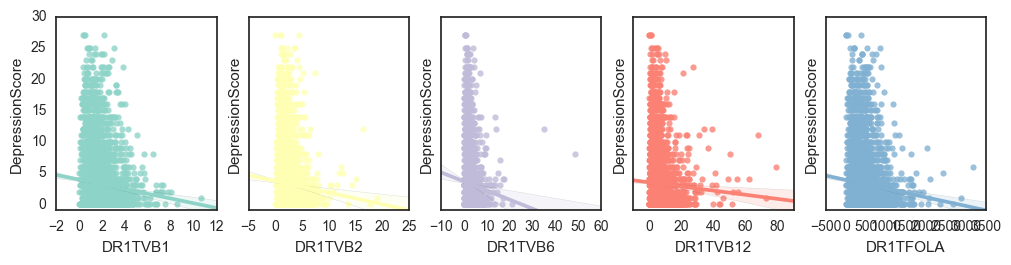

In [216]:
# correlation DepressionScore - vitamin

colors = sns.color_palette("Set3", len(vitamins_diet))

f, axes = plt.subplots(1, len(vitamins_diet), sharey=True, figsize=(12,2.5))

i=0
for vitamin in vitamins_diet:
    ax_curr = axes[i]
    ax_curr.set_ylim(-1,30)
    sns.regplot(x=vitamin, y='DepressionScore', data=df_vit_depr, color=colors[i], ax=ax_curr)
    ax_curr.set_xlabel(vitamin)
    ax_curr.set_ylabel('DepressionScore')
    i+=1
    
#plt.savefig('corr_test.eps')

In [219]:
vitamin_depression_cor_dict = {}
for vitamin in vitamins_diet:
    vitamin_depression_cor_dict[vitamin] = df_vit_depr['DepressionScore'].corr(df_vit_depr[vitamin])
vitamin_depression_cor_dict

{'DR1TFOLA': -0.081364602986803078,
 'DR1TVB1': -0.079483353753202923,
 'DR1TVB12': -0.038637551598552852,
 'DR1TVB2': -0.056649495834406739,
 'DR1TVB6': -0.05930282228472044}

There is no strong correlation between depression score and vitamin intake

#### Automatic feature selection ???

# TBC